In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline
import os

# Skimage
import skimage
import skimage.color
import skimage.transform
import skimage.feature
import skimage.io

/home/atanuc73/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
from sklearn.base import BaseEstimator , TransformerMixin
class rgb2gray_transform(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])
    

    
class Hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixals_per_cell=(8,8),cells_per_block=(3,3)):
        self.orientations=orientations
        self.pixals_per_cell=pixals_per_cell
        self.cells_per_block=cells_per_block
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features=skimage.feature.hog(img,orientations=self.orientations,
                                            pixels_per_cell=self.pixals_per_cell,
                                            cells_per_block=self.cells_per_block)
            
            return hog_features
        
        hfeatures=np.array([local_hog(x) for x in X])
        return hfeatures


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# pipeline model
image=skimage.io.imread("elephant.jpeg")

# Transform it into 80X80
image_resize=skimage.transform.resize(image,(80,80))
image_scale=255*image_resize
image_transform=image_scale.astype(np.uint8)

# RGB to GRAY
gray=skimage.color.rgb2gray(image_transform)
# Hog Feature
feature_vector=skimage.feature.hog(gray,orientations=10,
                                  pixels_per_cell=(8,8),
                                  cells_per_block=(2,2))

In [5]:
feature_vector

array([0.        , 0.        , 0.        , ..., 0.16082567, 0.25081797,
       0.21789461])

In [6]:
import pickle
# Load the Model
model=pickle.load(open('dsa_image_classification_sgd.pickle','rb'))
scaler=pickle.load(open("dsa_scaler.pickle","rb"))

In [7]:
feature_vector.shape

(3240,)

In [8]:
scalex=scaler.transform(feature_vector.reshape(1,-1))
result=model.predict(scalex)

In [9]:
result

array(['elephant'], dtype='<U8')

In [10]:
# Calculate The Probability
decision_value=model.decision_function(scalex)

In [11]:
decision_value

array([[-237.02600769, -286.71001118, -209.3477756 , -113.87781771,
        -214.63308396, -106.54292903,  -39.63609587, -173.37445117,
          20.62798692,  -84.35810647, -314.73116083, -390.66426869,
        -292.75851399, -157.01513869, -163.1979668 , -131.71830447,
        -127.59223954,  -48.96161625, -213.62099188, -322.04224277]])

In [12]:
labels=model.classes_
labels

array(['bear', 'cat', 'chicken', 'cow', 'deer', 'dog', 'duck', 'eagle',
       'elephant', 'human', 'lion', 'monkey', 'mouse', 'natural', 'panda',
       'pigeon', 'rabbit', 'sheep', 'tiger', 'wolf'], dtype='<U8')

In [13]:
decision_value=decision_value.flatten()
decision_value

array([-237.02600769, -286.71001118, -209.3477756 , -113.87781771,
       -214.63308396, -106.54292903,  -39.63609587, -173.37445117,
         20.62798692,  -84.35810647, -314.73116083, -390.66426869,
       -292.75851399, -157.01513869, -163.1979668 , -131.71830447,
       -127.59223954,  -48.96161625, -213.62099188, -322.04224277])

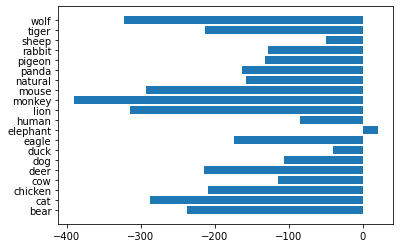

In [14]:
plt.barh(labels,decision_value);

In [15]:
# Calculate The Z Score
z=scipy.stats.zscore(decision_value)
prob_value=scipy.special.softmax(z)
prob_value

array([0.01825005, 0.01130472, 0.02383088, 0.05981765, 0.02264712,
       0.06420032, 0.12236174, 0.03370886, 0.2187479 , 0.07950875,
       0.00862875, 0.00415002, 0.01066442, 0.0394669 , 0.03718334,
       0.05036622, 0.0524099 , 0.11184174, 0.02286916, 0.00804155])

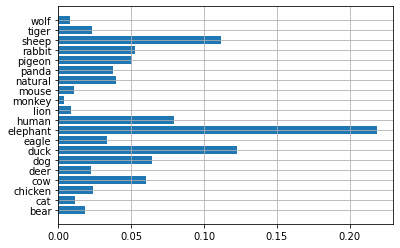

In [16]:
plt.barh(labels,prob_value)
plt.grid()

In [17]:
# top five probabilty values
top_5_prob_ind = prob_value.argsort()[::-1][:5]
top_5_prob_ind

array([ 8,  6, 17,  9,  5])

In [18]:
top_labels = labels[top_5_prob_ind]
top_prob = prob_value[top_5_prob_ind]
top_dict=dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,2)})

In [19]:
top_dict

{'elephant': 0.22, 'duck': 0.12, 'sheep': 0.11, 'human': 0.08, 'dog': 0.06}

In [23]:
def pipeline_model(path,scaler_transform,model_sgd):
    # Pipeline Model
    image=skimage.io.imread(path)
    # Transform image into 80 X 80
    image_resize=skimage.transform.resize(image,(80,80))
    image_scale=255 * image_resize
    image_transform=image_scale.astype(np.uint8)
    # RGB to GRAY
    gray=skimage.color.rgb2gray(image_transform)
    # Hog Feature
    feature_vector=skimage.feature.hog(gray,orientations=10,pixels_per_cell=(8,8),
                                      cells_per_block=(2,2))
    # Scaling
    scalex=scaler_transform.transform(feature_vector.reshape(1,-1))
    result=model_sgd.predict(scalex)
    # Decision function # Confidence
    decision_value=model_sgd.decision_function(scalex).flatten()
    labels=model_sgd.classes_
    # probability
    z=scipy.stats.zscore(decision_value)
    prob_value=scipy.special.softmax(z)
    
    # Top 5
    top_5_prob_ind=prob_value.argsort()[::-1][:5]
    top_labels = labels[top_5_prob_ind]
    top_prob = prob_value[top_5_prob_ind]
    # put it in Dictionary
    top_dict={}
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,3)})
        
    return top_dict


In [24]:
res=pipeline_model('elephant.jpeg',scaler,model)
res

{'elephant': 0.219, 'duck': 0.122, 'sheep': 0.112, 'human': 0.08, 'dog': 0.064}